# Train and test on 50/50 dataset balance

In [2]:
import pandas as pd
import shutil
import random
from DicomRTTool.ReaderWriter import DicomReaderWriter, ROIAssociationClass
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
import pickle
import json
import torch.nn.functional as F
import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
from sklearn.preprocessing import label_binarize
import wandb

## Make smaller negative dataset

In [3]:
df = pd.read_csv(r'/home/lam3654/MSAI_pneumonitis/toxicity_anon.csv')
neg_large_value = df.loc[df['pneumonitis'] == 0, 'anon_id']
neg_large_value = list(neg_large_value)
random.shuffle(neg_large_value)

count = 0
for value in neg_large_value:
    if count < 49:
        print(value)
        source_folder = '/home/lam3654/MSAI_pneumonitis/data/DataUsedForAnalysis/{}/'.format(value)
        destination_folder = '/home/lam3654/MSAI_pneumonitis/data/small_pneumonitis_negative/{}/'.format(value)
        
        # Copy the entire folder and its contents recursively
        shutil.copytree(source_folder, destination_folder)
        count += 1

P0222
P0644
P0973
P1072
P0848
P1146
P1219
P0948
P0028
P0511
P0665
P1058
P0639
P1067
P1061
P0963
P1092
P0541
P1241
P0296
P0970
P0660
P0652
P1291
P0284
P0183
P0529
P1119
P0972
P0820
P0496
P0801
P0983
P0475
P1217
P0957
P0050
P1276
P0659
P1215
P0311
P1104
P1186
P1202
P0996
P0699
P1147
P1106
P0595


In [4]:
df = pd.read_excel(r'/home/lam3654/MSAI_pneumonitis/label.xlsx')
# Select values from one column based on the value of another
neg_small_value = df.loc[df['pneumonitis'] == 0, 'anon_id']
neg_small_value = list(neg_small_value)
random.shuffle(neg_small_value)



count = 0
# Iterate over the values
for value in neg_small_value:
    print(value)
    source_folder = '/home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/{}/'.format(value)
    destination_folder = '/home/lam3654/MSAI_pneumonitis/data/small_pneumonitis_negative/{}/'.format(value)
    if os.path.exists(source_folder):
        if count<16:
            print('source folder found: ', source_folder)
            # Copy the entire folder and its contents recursively
            shutil.copytree(source_folder, destination_folder)
            print(value, 'added')
            count +=1 

NU_0092
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0092/
NU_0092 added
NU_0171
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0171/
NU_0171 added
NU_0283B
NU_0214
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0214/
NU_0214 added
NU_0012B
NU_0078
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0078/
NU_0078 added
NU_0003
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0003/
NU_0003 added
NU_0116
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0116/
NU_0116 added
NU_0068
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0068/
NU_0068 added
NU_0247
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0247/
NU_0247 added
NU_0263
NU_0034
source folder found:  /home/lam3654/MSAI_pneumonitis/data/combined_BATCHES/NU_0034/
NU_0034 added
NU_0107
source folde

## Train/dev/test split

In [6]:
positive_folder = r'/home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive'
negative_folder = r'/home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative'

# Load the data and labels
positive_data = [os.path.join(positive_folder, filename) for filename in os.listdir(positive_folder)]
negative_data = [os.path.join(negative_folder, filename) for filename in os.listdir(negative_folder)]
data = positive_data + negative_data
labels = [1] * len(positive_data) + [0] * len(negative_data)

# Shuffle the data and labels together
combined_data = list(zip(data, labels))
random.shuffle(combined_data)
data, labels = zip(*combined_data)

# Determine the sizes of each set
train_size = int(0.7 * len(data))
dev_size = int(0.15 * len(data))

# Split the data into train, dev, and test sets
train_data, remaining_data, train_labels, remaining_labels = train_test_split(data, labels, train_size=train_size, stratify=labels)
dev_data, test_data, dev_labels, test_labels = train_test_split(remaining_data, remaining_labels, train_size=dev_size/(len(data)-train_size), stratify=remaining_labels)

# Print the sizes of each set
print(f"Train set size: {len(train_data)}")
print(f"Dev set size: {len(dev_data)}")
print(f"Test set size: {len(test_data)}")



Train set size: 86
Dev set size: 18
Test set size: 19


In [7]:
path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/train_dev_test_lists'

In [8]:
with open(os.path.join(path, "small_train_data.json"), "w") as file:
    json.dump(train_data, file)

with open(os.path.join(path, "small_train_labels.json"), "w") as file:
    json.dump(train_labels, file)

with open(os.path.join(path, "small_dev_data.json"), "w") as file:
    json.dump(dev_data, file)

with open(os.path.join(path, "small_dev_labels.json"), "w") as file:
    json.dump(dev_labels, file)

with open(os.path.join(path, "small_test_data.json"), "w") as file:
    json.dump(test_data, file)

with open(os.path.join(path, "small_test_labels.json"), "w") as file:
    json.dump(test_labels, file)

In [9]:
with open(os.path.join(path, "small_train_data.json"), "r") as file:
    train_data = json.load(file)

with open(os.path.join(path, "small_train_labels.json"), "r") as file:
    train_labels = json.load(file)

## Create Dataset

In [10]:
## set number of skipped slices
skip = 4

In [11]:
lung_list = ['both lungs', 'lung_whole', 'total lung', 'combo lung', 'combined lung', 'whole lung', 'lungs', 'whole_lung', 'composite lung', 'combo lungs']


In [12]:
total_arrays = []
total_labels = []
skipped_scans = []

for i in range(len(train_data)):
    try:
        single_arrays = []
        Dicom_path = train_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [train_labels[i] for x in range(len(single_arrays))]
        total_arrays = total_arrays + single_arrays
        total_labels = total_labels + single_labels
    except TypeError:
        print("skip this dataset")
        skipped_scans.append(train_data[i])
        continue

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 2, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Finished listing present indexes
Loading images for AVG 0

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_RTst_2018-10-21_105503_SBRT.Chest.planning.scan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_RTDOSE_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_RTPLAN_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_CT_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n177__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_RTPLAN_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n1__00000/2.16.840.1.114362.1.11940992.22933840372.56904

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53it/s]


Compiling dictionaries together...
Index 0, description NU_0171  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_CT_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_CT_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n177__00000
Finished listing present indexes
Loading images for NU_0171  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0171/2018-10__Studies/NU.0171_NU.0171_CT_2018-10-21_105503_SBRT.Chest.planning.scan_NU.0171_n177__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1146


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Compiling dictionaries together...
Index 0, description KV_BM_Research at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1146
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1146
Finished listing present indexes
Loading images for KV_BM_Research at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1146

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_RTst_2012-08-30_110406_SBRT.planning.+.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_RTDOSE_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_CT_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n148__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_RTPLAN_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_RTPLAN_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052778.

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Compiling dictionaries together...
Index 0, description NU_0034  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_CT_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n148__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_CT_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n148__00000
Finished listing present indexes
Loading images for NU_0034  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0034/2012-08__Studies/NU.0034_NU.0034_CT_2012-08-30_110406_SBRT.planning.+.bellows_NU.0034_n148__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_CT_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n172__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_RTPLAN_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_RTst_2014-12-15_150552_Sbrt.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_RTDOSE_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_RTPLAN_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052830.195.2946.d

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


Compiling dictionaries together...
Index 0, description NU_0068  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_CT_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n172__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_CT_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n172__00000
Finished listing present indexes
Loading images for NU_0068  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0068/2014-12__Studies/NU.0068_NU.0068_CT_2014-12-15_150552_Sbrt.planning.bellows_NU.0068_n172__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.20s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Contour names or associations changed

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.38s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1119

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0311


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0311
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0311
Finished listing present indexes
Loading images for abc 1; AVG BODY/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0311

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.77s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.93s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1291

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.21s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 1, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 5, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/dat

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_CT_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n151__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_RTst_2010-12-07_105001_SBRT.planning.and.gating_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_RTPLAN_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_RTDOSE_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_RTPLAN_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n1__00000/2.16.840.1.114362.1.11940992.22933840372.56905

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.55it/s]


Compiling dictionaries together...
Index 0, description NU_0162  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_CT_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n151__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_CT_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n151__00000
Finished listing present indexes
Loading images for NU_0162  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0162/2010-12__Studies/NU.0162_NU.0162_CT_2010-12-07_105001_SBRT.planning.and.gating_NU.0162_n151__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumoniti

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_CT_2016-02-20_133757_sbrt.planning_NU.0078_n125__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_RTDOSE_2016-02-20_133757_sbrt.planning_NU.0078_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_RTPLAN_2016-02-20_133757_sbrt.planning_NU.0078_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_RTst_2016-02-20_133757_sbrt.planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_RTPLAN_2016-02-20_133757_sbrt.planning_NU.0078_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055736.988.2648.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]


Compiling dictionaries together...
Index 0, description NU_0078  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_CT_2016-02-20_133757_sbrt.planning_NU.0078_n125__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_CT_2016-02-20_133757_sbrt.planning_NU.0078_n125__00000
Finished listing present indexes
Loading images for NU_0078  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0078/2016-02__Studies/NU.0078_NU.0078_CT_2016-02-20_133757_sbrt.planning_NU.0078_n125__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTDOSE_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTst_2012-09-23_092750_SBRT.Lung.Plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052816.114.2423.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.32it/s]


Compiling dictionaries together...
Index 0, description NU_0062  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Finished listing present indexes
Loading images for NU_0062  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.04s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0660. Found []
Contour n

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1241


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1241
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1241. Found ['lung_l', 'lung_r', 'ptv', 'great vessels', 'spinal cord+5mm', 'trachea', 'esophagus', 'lung_total', 'heart', 'spinal cord', 'ct itv', 'skin-5mm', 'bronchial tree_proximal', 'ptv+2cm', 'bronchial tree_proximal+2cm', 'ribs_r, 5cm', 'outer contour', 'isocenter', 'gtv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.85s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 2, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957
Index 1, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0957

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.63s/it]


Compiling dictionaries together...
Index 0, description Mean IP: Derived CT 20150724 144420  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 5, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1084
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lackin

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.20s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found ['wall of ptv (free+rtog)', 'free breathing gtv', 'outer contour', 'ptv (free+rtog)', 'exhale gtv', 'inhale gtv', 'brachial plexus', 'proximal bronchial tree', 'trachea', 'left lung', 'heart', 'esophagus', 'spinal cord']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumoni

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1202


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1202
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1202
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1202

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529
Index 1, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0529

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:00<00:00, 14.95it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTDOSE_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTPLAN_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTst_2013-06-08_091351_RUL.SBRT.planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_RTPLAN_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053534.550.8050.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]


Compiling dictionaries together...
Index 0, description NU_0072  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0072/2013-06__Studies/NU.0072_NU.0072_CT_2013-06-08_091351_RUL.SBRT.planning_NU.0072_n184__00000. Found ['lung_l1', 'lung_r1', 'itv rul nodule', 'ptv rul nodule', 'gtv_research_tpct', 'r lung - gtv', 'r lung - itv', 'gtv + 2 cm', 'tl-gtv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTDOSE_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTst_2010-11-28_101205_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049584.1068.2998.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


Compiling dictionaries together...
Index 0, description NU_0163  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Finished listing present indexes
Loading images for NU_0163  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.67s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0963. Found []
Lacking ['lung'] in index 3, location 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183
Index 1, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0183

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.66s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumoniti

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.75s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 4, description THORAX  1.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1181. Found []
Lacking ['lung'] in index 3, location /home/lam3654/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.97s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 1, description OBESE CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 3, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 4, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneu

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.03s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 1, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 6, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0028
I

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.14s/it]


Compiling dictionaries together...
Index 0, description iDose (3)  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 2, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Finished listing present indexes
Loading images for iDose (3)  at 
 /home/lam3654/MSAI_pneumonitis/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.32s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1215
Fin

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 3, description CHEST w/o  5.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Contour nam

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.58s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 3, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 6, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 7, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0567
Index 8, description None at None
9 unique series IDs were fo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203. Found ['iso lul', 'cord', 'esophagus', 'external', 'gtv free', 'heart', 'ipsi bp', 'itv', 'lung_l', 'pbt', 'ptv', 'trachea', 'ptv_2cm', '1', 'ptv 3mm']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Compiling dictionaries together...
Index 0, description Mean IP: Derived CT 20170620 144342  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820
Finished listing present indexes
Loading images for Mean IP: Derived CT 20170620 144342  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0820

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTst_2012-08-28_091754_sbrt.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTDOSE_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569563285.897.1288.d

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


Compiling dictionaries together...
Index 0, description NU_0107  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Finished listing present indexes
Loading images for NU_0107  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.39s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 1, description Axial Mediastinum Chest 3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 3, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0889. 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_RTDOSE_2016-08-24_090538_SBRT.lung.planning_NU.0214_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_CT_2016-08-24_090538_SBRT.lung.planning_NU.0214_n159__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_RTst_2016-08-24_090538_SBRT.lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_RTPLAN_2016-08-24_090538_SBRT.lung.planning_NU.0214_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_RTPLAN_2016-08-24_090538_SBRT.lung.planning_NU.0214_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569047993.1023.2137.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_CT_2016-08-24_090538_SBRT.lung.planning_NU.0214_n159__00000
Compiling dictionaries together...
Index 0, description NU_0214  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_CT_2016-08-24_090538_SBRT.lung.planning_NU.0214_n159__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_CT_2016-08-24_090538_SBRT.lung.planning_NU.0214_n159__00000
Finished listing present indexes
Loading images for NU_0214  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0214/2016-08__Studies/NU.0214_NU.0214_C

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.82s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1224
Index 7, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284
Finished listing present indexes
Loading images for abc 1; AVG BODY/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0284

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTst_2010-03-23_104049_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTDOSE_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051033.962.694.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s]


Compiling dictionaries together...
Index 0, description NU_0196  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Finished listing present indexes
Loading images for NU_0196  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTDOSE_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTst_2012-05-20_143510_SBRT.Lung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055783.

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Compiling dictionaries together...
Index 0, description NU_0235  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Finished listing present indexes
Loading images for NU_0235  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0235/2012-05__Studies/NU

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.18s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Contour n

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.33s/it]


Compiling dictionaries together...
Index 0, description AVG 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016. Found []
Lacking [

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 13.13it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTDOSE_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTst_2013-02-08_150300_SBRT.RLung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055756.363.5066.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


Compiling dictionaries together...
Index 0, description NU_0199  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Finished listing present indexes
Loading images for NU_0199  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.69s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 3, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 4, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 6, description AXIAL MEDIASTINUM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(ind

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTst_2017-08-01_093310_SBRT.Lung_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTDOSE_2017-08-01_093310_SBRT.Lung_._n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000/2.16.840.1.114362.1.12046989.24327927514.609546435.590.354.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.98s/it]


Compiling dictionaries together...
Index 0, description O-MAR  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0644. Found []
Lacking ['lung'] i

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.24s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 2, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0535
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Contour names or associations changed, resettin

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.17s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1058


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1058
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1058
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1058

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.92s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 4, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 2, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTst_2018-12-01_145941_SBRT.Chest.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTDOSE_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052301.996.1566.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.31it/s]


Compiling dictionaries together...
Index 0, description NU_0063  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Finished listing present indexes
Loading images for NU_0063  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 18.05it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_RTPLAN_2018-07-11_162227_sbrt.lung.planning_NU.0019_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_CT_2018-07-11_162227_sbrt.lung.planning_NU.0019_n158__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_RTDOSE_2018-07-11_162227_sbrt.lung.planning_NU.0019_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_RTst_2018-07-11_162227_sbrt.lung.planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_RTPLAN_2018-07-11_162227_sbrt.lung.planning_NU.0019_n1__00000/2.16.840.1.114362.1.11940992.24327927514.584609494.501.403.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]


Compiling dictionaries together...
Index 0, description NU_0019  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_CT_2018-07-11_162227_sbrt.lung.planning_NU.0019_n158__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_CT_2018-07-11_162227_sbrt.lung.planning_NU.0019_n158__00000
Finished listing present indexes
Loading images for NU_0019  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0019/2018-07__Studies/NU.0019_NU.0019_CT_2018-07-11_162227_sbrt.lung.planning_NU.0019_n158__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.20s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 2, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0665
Ind

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0296


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0296
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0296
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0296

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.68s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Finished listing present indexes
Loading images for A

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.72s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0541. Found []
Lacking ['lu

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTst_2015-12-10_133644_SBRT.Lung.plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTDOSE_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051644.954.9.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.29it/s]


Compiling dictionaries together...
Index 0, description NU_0152  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Finished listing present indexes
Loading images for NU_0152  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0972


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0972
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0972
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0972

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  75%|████████████████████████████████████████████████████▌                 | 3/4 [00:00<00:00, 22.62it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_RTst_2011-07-19_115424_SBRT.Lung.Planning_JR.GTV_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_CT_2011-07-19_115424_SBRT.Lung.Planning_NU.0247_n190__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_RTDOSE_2011-07-19_115424_._NU.0247_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_RTPLAN_2011-07-19_115424_._NU.0247_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_RTPLAN_2011-07-19_115424_._NU.0247_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569572204.1092.7363.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


Compiling dictionaries together...
Index 0, description NU_0247  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_CT_2011-07-19_115424_SBRT.Lung.Planning_NU.0247_n190__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0247/2011-07__Studies/NU.0247_NU.0247_CT_2011-07-19_115424_SBRT.Lung.Planning_NU.0247_n190__00000. Found ['gtv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.60s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 5, description PE CHEST  1.0  B30f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0639
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [01:17<00:00, 77.80s/it]


Compiling dictionaries together...
Index 0, description ABC 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1186
I

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.35s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1219. Found []
Lacking ['lung'] in index 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTPLAN_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTDOSE_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTst_2011-12-12_110757_SBRT.Lung.planning..bellows_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_RTPLAN_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049358.706.4636.d

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


Compiling dictionaries together...
Index 0, description NU_0190  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000
Finished listing present indexes
Loading images for NU_0190  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0190/2011-12__Studies/NU.0190_NU.0190_CT_2011-12-12_110757_SBRT.Lung.planning..bellows_NU.0190_n196__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.08s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 1, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 2, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 5, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 6, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1276
Index 7, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1147


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.74s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1147
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1147
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1147

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.94s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1092
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.64s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.63s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 5, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0801
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MS

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.08s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320. Found ['esophagus', 'gtv in', 'gtv ex', 'gtv 1st gtv exhale union', 'gtv 1st', 'outer contour', 'rt lung', 'cord', 'heart', 'itv', 'ptv', 'trachea', 'pbt', 'esophagus wall', 'airway', 'airway wall', 'new right lung']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.35s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 4, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 5, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0496
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung']

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0973


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


Compiling dictionaries together...
Index 0, description O-MAR, iDose (3) at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0973
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0973
Finished listing present indexes
Loading images for O-MAR, iDose (3) at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0973

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_RTPLAN_2018-07-13_153554_MInIP.SBRT.chest.plan.and.bellows_NU.0026_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_RTDOSE_2018-07-13_153554_MInIP.SBRT.chest.plan.and.bellows_NU.0026_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_CT_2018-07-13_153554_SBRT.chest.plan.and.bellows_NU.0026_n161__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_RTst_2018-07-13_153554_SBRT.chest.plan.and.bellows_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_RTPLAN_2018-07-13_153554_MInIP.SBRT.chest.plan.and.bellows_NU.0026_n1__00000/2.16.840.1.11

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]


Compiling dictionaries together...
Index 0, description NU_0026  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_CT_2018-07-13_153554_SBRT.chest.plan.and.bellows_NU.0026_n161__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_CT_2018-07-13_153554_SBRT.chest.plan.and.bellows_NU.0026_n161__00000
Finished listing present indexes
Loading images for NU_0026  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0026/2018-07__Studies/NU.0026_NU.0026_CT_2018-07-13_153554_SBRT.chest.plan.and.bellows_NU.0026_n161__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.91s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0848. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_nega

Loading through DICOM files:   0%|                                                                              | 0/2 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0237/2019-02__Studies/NU.0237_NU.0237_RTDOSE_2019-02-14_122558_SBRT.Chest.Planning_NU.0237_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0237/2019-02__Studies/NU.0237_NU.0237_CT_2019-02-14_122558_SBRT.Chest.Planning_NU.0237_n170__00000


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]

failed on /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0237/2019-02__Studies/NU.0237_NU.0237_CT_2019-02-14_122558_SBRT.Chest.Planning_NU.0237_n170__00000
Compiling dictionaries together...
Index 0, description NU_0237  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0237/2019-02__Studies/NU.0237_NU.0237_CT_2019-02-14_122558_SBRT.Chest.Planning_NU.0237_n170__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0237/2019-02__Studies/NU.0237_NU.0237_CT_2019-02-14_122558_SBRT.Chest.Planning_NU.0237_n170__00000. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


In [13]:
print(skipped_scans)

['/home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887']


## Save array and label lists

In [14]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [21]:
print(type(total_arrays))

<class 'list'>


In [29]:
np.save(os.path.join(np_folder_path, "small_train_arrays.npy"), total_arrays)

with open(os.path.join(np_folder_path, "small_train_labels_np.json"), "w") as file:
    json.dump(total_labels, file)

## Build dataset

In [22]:
class CTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

In [23]:
# loaded_array_list = np.load(os.path.join(np_folder_path, "small_train_arrays.npy"), allow_pickle=True)
loaded_array_list = total_arrays

with open(os.path.join(np_folder_path, "small_train_labels_np.json"), "r") as file:
    train_labels_list = json.load(file)

In [33]:
print(sum(train_labels_list))
print(len(train_labels_list))
print(749/1661)

749
1661
0.4509331727874774


In [24]:
dataset = CTDataset(loaded_array_list, train_labels_list)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

## Define model structure

In [25]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training

Training on cuda:0
Epoch [1/10], Loss: 0.0007
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


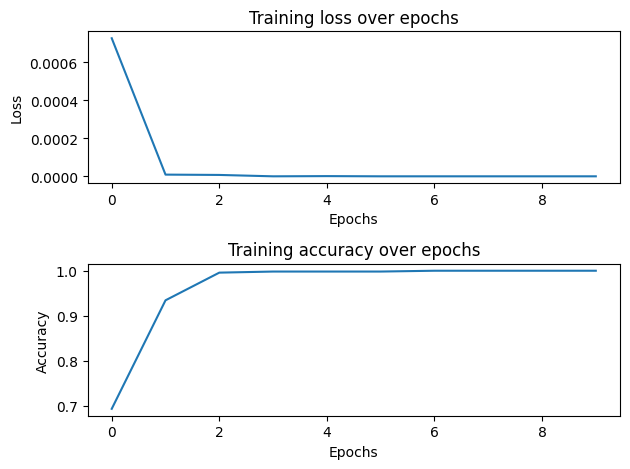

In [37]:
# Check if a GPU is available and if not, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Initialize the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_list = []
loss_list = []


output_list = []
num_epochs = 10 
for epoch in range(num_epochs):
    true_labels = []
    pred_labels = []
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)  # Get the predicted classes

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

        # Backward and optimize
        loss.backward()
        optimizer.step()

    # Convert to numpy arrays for use with sklearn
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    accuracy_list.append(accuracy)
    loss_list.append(loss.item())
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

x_list = [x for x in range(num_epochs)]

plt.subplot(2, 1, 1)  # (rows, columns, subplot index)
plt.plot(x_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over epochs')

# Create the second subplot
plt.subplot(2, 1, 2)  # (rows, columns, subplot index)
plt.plot(x_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy over epochs')

# Adjust the spacing between plots
plt.tight_layout()

# Display the plots
plt.show()


## Testing

In [27]:
with open(os.path.join(path, "small_test_data.json"), "r") as file:
    test_data = json.load(file)

with open(os.path.join(path, "small_test_labels.json"), "r") as file:
    test_labels = json.load(file)

In [28]:
total_test_arrays = []
total_test_labels = []
missed_list = []

for i in range(len(test_data)):
    try:
        single_arrays = []
        Dicom_path = test_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [test_labels[i] for x in range(len(single_arrays))]
        total_test_arrays = total_test_arrays + single_arrays
        total_test_labels = total_test_labels + single_labels
    except TypeError:
        print("skip this dataset")
        missed_list.append(test_data[i])
        continue

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.64s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 1, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 2, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 3, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 4, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 5, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 6, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1067
Index 7, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_ne

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0222


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0222
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0222
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0222

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.11s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 2, description CHEST  1.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 4, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 6, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 8, description None at None
9 unique series IDs were foun

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.55it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTDOSE_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTst_2016-07-30_083030_SBRT.lung.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048698.1055.7021.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.02s/it]


Compiling dictionaries together...
Index 0, description NU_0035  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Finished listing present indexes
Loading images for NU_0035  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1199

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_RTDOSE_2016-12-05_133854_SBRT.lung.planning_NU.0092_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_RTst_2016-12-05_133854_SBRT.lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_CT_2016-12-05_133854_SBRT.lung.planning_NU.0092_n129__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_RTPLAN_2016-12-05_133854_SBRT.lung.planning_NU.0092_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_RTPLAN_2016-12-05_133854_SBRT.lung.planning_NU.0092_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052445.673.7788.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.69it/s]


Compiling dictionaries together...
Index 0, description NU_0092  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_CT_2016-12-05_133854_SBRT.lung.planning_NU.0092_n129__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_CT_2016-12-05_133854_SBRT.lung.planning_NU.0092_n129__00000
Finished listing present indexes
Loading images for NU_0092  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0092/2016-12__Studies/NU.0092_NU.0092_CT_2016-12-05_133854_SBRT.lung.planning_NU.0092_n129__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.33s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 6, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
Index 7, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0970
8 unique seri

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.41s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0699
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1,

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.79s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 3, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 6, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0511
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung']

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 11.66it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_CT_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n169__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_RTDOSE_2018-06-01_135234_SBRT.lung.planning.scan_Coron_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_RTst_2018-06-01_135234_SBRT.lung.planning.scan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_RTPLAN_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_RTPLAN_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051724.87

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


Compiling dictionaries together...
Index 0, description NU_0003  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_CT_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n169__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_CT_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n169__00000
Finished listing present indexes
Loading images for NU_0003  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0003/2018-06__Studies/NU.0003_NU.0003_CT_2018-06-01_135234_SBRT.lung.planning.scan_NU.0003_n169__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.32s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P0595
Index 8, de

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.16s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Foun

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1217


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1217
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1217
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/P1217

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.08s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 1, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 2, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 3, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 4, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 5, description PE CHEST  1.0  B30f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneu

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_CT_2019-04-11_095832_SBRT.Lung.Planning.Scan_NU.0012C_n180__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_RTst_2019-04-11_095832_SBRT.Lung.Planning.Scan_AY.0012A_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_RTPLAN_2019-04-11_095832_MinIP.SBRT.Lung.Planning.Scan_NU.0012C_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_RTDOSE_2019-04-11_095832_MinIP.SBRT.Lung.Planning.Scan_NU.0012C_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_RTPLAN_2019-04-11_095832_MinIP.SBRT.Lung.Planning.Scan_NU.0012C_n1__00000/2.16.840

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


Compiling dictionaries together...
Index 0, description NU_0012C at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_CT_2019-04-11_095832_SBRT.Lung.Planning.Scan_NU.0012C_n180__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_CT_2019-04-11_095832_SBRT.Lung.Planning.Scan_NU.0012C_n180__00000
Finished listing present indexes
Loading images for NU_0012C at 
 /home/lam3654/MSAI_pneumonitis/data/train/small_pneumonitis_negative/NU_0012A/2019-04__Studies/NU.0012C_NU.0012C_CT_2019-04-11_095832_SBRT.Lung.Planning.Scan_NU.0012C_n180__00000

Erasing any previous mask as we load a new new image set


In [30]:
np.save(os.path.join(np_folder_path, "small_test_arrays.npy"), total_test_arrays)

with open(os.path.join(np_folder_path, "small_test_labels_np.json"), "w") as file:
    json.dump(total_test_labels, file)

In [34]:
test_array_list = np.load(os.path.join(np_folder_path, "small_test_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "small_test_labels_np.json"), "r") as file:
    test_labels_list = json.load(file)

In [35]:
test_dataset = CTDataset(test_array_list, test_labels_list)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

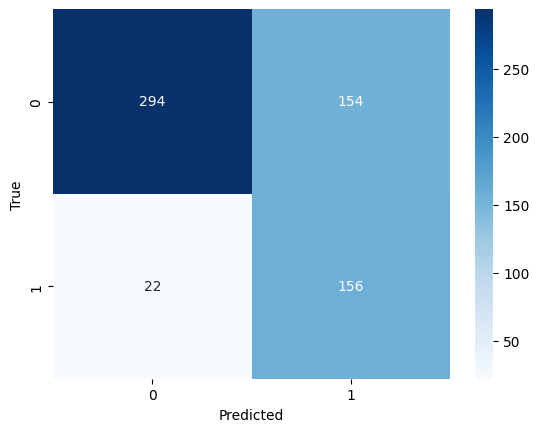

Accuracy: 0.7188498402555911
ROC AUC: 0.7663272471910112


In [36]:
model = model.to(device)
model.eval()  # Set the model to evaluation mode

true_labels = []
pred_labels = []
outputs_list = []

# Loop through the test data
for inputs, labels in test_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[:, np.newaxis, :, :]
    inputs = inputs.float()


    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)  # Get the predicted classes

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    outputs_list.extend(outputs.detach().cpu().numpy())

# Convert to numpy arrays for use with sklearn
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute ROC AUC
roc_auc = roc_auc_score(label_binarize(true_labels, classes=[0,1]),
                        label_binarize(pred_labels, classes=[0,1]), 
                        average='macro')

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
